# Ejercicio 2: Regresión logística


---

Construir un modelo de regresión logística en el lugar señalado en el archivo chess_dataset.csv (presente en los archivos de la clase 4) e implementen su propio modelo de ajedrez que juegue contra sí mismo la posición denominada Ataque Marshall.


## 1. Instalación de librerías

Se instalan las librerías necesarias para el procesamiento de datos, manipulación de imágenes y manejo del ajedrez.

In [ ]:
!pip install chess
!pip install wand

In [ ]:
!apt-get update  # Update the package list
!apt-get install imagemagick  # Install ImageMagick
!apt-get install libmagickwand-dev  # Install MagickWand development headers

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 128 kB in 4s (29.2 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Don

## 2. Importación de librerías

Se importan las librerías requeridas para la manipulación de datos, el desarrollo del modelo y la visualización de resultados.

In [ ]:
import pandas as pd
import chess
import numpy as np
import random
import chess.svg
from wand.image import Image as WandImage
import io
from PIL import Image
from sklearn.metrics import accuracy_score

## 3. Carga y exploración de datos
Se cargan los datos del dataset de ajedrez y se realiza una exploración inicial para entender su estructura y características principales.

In [ ]:
# Cargar datos
df = pd.read_csv('/content/chess_dataset.csv')
df = df.sample(int(len(df)/25))

# Exploración inicial del DataFrame de ajedrez
df.head()

,game_id,position_id,fen,diff_pawn,diff_knight,diff_bishop,diff_rook,diff_queen,pst_pawn,pst_knight,pst_bishop,pst_rook,pst_queen,white_wins
903053,game_53172,25,rn2k2r/pp1b1q1p/2p1pPp1/3p4/3P4/3B1Q2/PPP3PP/R...,0,0,0,0,0,42,0,15,33,-13,0
768002,game_45256,21,rn1q1rk1/5ppp/2pb1n2/pp1p1b2/3P4/1BN1PN2/PPP1Q...,0,0,-1,0,0,-44,33,-12,0,-2,0
1276258,game_75103,33,r3brk1/p5p1/2pqpn1p/3pNp2/1P1P4/2PB1P2/P3Q1PP/...,0,0,0,0,0,-18,20,28,0,10,0
1176102,game_69197,26,rn2k2r/1pp2ppp/p2qp3/1B6/3P4/BQP1PP2/P5PP/1R2K...,0,-1,2,0,0,-1,21,5,6,4,1
1592242,game_93814,33,7r/Q1p2kpp/3bq3/4p3/8/3pB3/PP3PPP/n4K1R w - - ...,0,-1,0,0,0,-40,167,-1,0,-19,0



Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 67858 entries, 903053 to 1673933
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   game_id      67858 non-null  object
 1   position_id  67858 non-null  int64 
 2   fen          67858 non-null  object
 3   diff_pawn    67858 non-null  int64 
 4   diff_knight  67858 non-null  int64 
 5   diff_bishop  67858 non-null  int64 
 6   diff_rook    67858 non-null  int64 
 7   diff_queen   67858 non-null  int64 
 8   pst_pawn     67858 non-null  int64 
 9   pst_knight   67858 non-null  int64 
 10  pst_bishop   67858 non-null  int64 
 11  pst_rook     67858 non-null  int64 
 12  pst_queen    67858 non-null  int64 
 13  white_wins   67858 non-null  int64 
dtypes: int64(12), object(2)
memory usage: 7.8+ MB
None

Estadísticas descriptivas:
        position_id     diff_pawn   diff_knight   diff_bishop     diff_rook  \
count  67858.000000  67858.000000 

<Axes: >

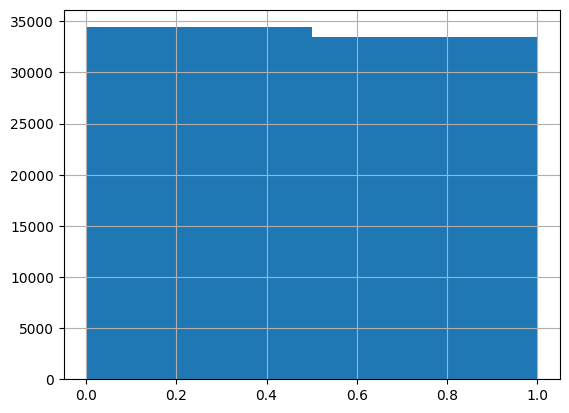

In [ ]:
print('\nInformación general del DataFrame:')
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

print("\nCantidad de valores nulos por columna:")
print(df.isnull().sum())

print("\nDistribución de la variable objetivo (white_wins):")
print(df['white_wins'].value_counts())
df['white_wins'].hist(bins=2)

## 4. Preparación de los datos
Se seleccionan variables predictoras (`diff_pawn`, `diff_knight`, etc.) y la variable objetivo (`white_wins`), que se utilizarán para entrenar el modelo de regresión logística.

In [ ]:
X=df[["diff_pawn",	"diff_knight",	"diff_bishop",
      "diff_rook",	"diff_queen","pst_pawn",	"pst_knight",
          	"pst_bishop",	"pst_rook",	"pst_queen"]]
y=df["white_wins"]

## 5. Definición del Modelo de Regresión Logística Manual
Se implementa desde cero la clase de Regresión Logística (`RegLog`), incluyendo la función sigmoide, el entrenamiento mediante Newton-Raphson y los métodos de predicción y score.

In [ ]:
# Creo una función para la función sigmoide
def sigmoide(x):# Función sigmoide
  return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),              # Para x >= 0
        np.exp(x) / (1 + np.exp(x))        # Para x < 0 (evita overflow positivo)
    )

# Construyo la regresión logística
class RegLog():
    # Inicializo la clase
    def __init__(self):
        self.params = np.zeros(10)  # Se sobreescribirá después con el tamaño correcto
        self.trained = False
        print("¡Modelo inicializado!")

    # Método de entrenamiento con Newton-Raphson
    def fit(self, X_train, y_train, max_iter=100, convergence_rate=1e-5, verb=True):
        # Agregar columna de 1s para el intercepto
        X = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        y = y_train

        # Inicializar parámetros
        self.params = np.zeros(X.shape[1])

        for i in range(max_iter):
            z = X @ self.params
            y_pred = sigmoide(z)

            # Gradiente: X.T @ (y_pred - y)
            gradiente = X.T @ (y_pred - y)

            # Matriz diagonal W con p*(1-p)
            W_diag = y_pred * (1 - y_pred)
            W = np.diag(W_diag)

            # Hessiano: X.T @ W @ X
            hessiano = X.T @ W @ X

            # Resolver delta: H^{-1} @ gradiente
            try:
                delta = np.linalg.inv(hessiano) @ gradiente
            except np.linalg.LinAlgError:
                #print("Matriz singular, usando pseudo-inversa")
                delta = np.linalg.pinv(hessiano) @ gradiente

            # Actualizar parámetros
            self.params -= delta

            # Criterio de convergencia
            if np.linalg.norm(delta) < convergence_rate:
                if verb:
                    print(f"Convergencia alcanzada en iteración {i}")
                self.trained = True
                return

        if verb:
            print("Máximo de iteraciones alcanzado")
        self.trained = True

    # Devuelve los coeficientes del modelo
    def get_params(self):
        if not self.trained:
            raise Exception('El modelo no está entrenado.')
        else:
            return self.params

    # Predicción probabilística
    def predict_proba(self, X_test):
        if not self.trained:
            raise Exception('El modelo no está entrenado.')
        # Tengo que agregar una columna de 1s para calcular el intercepto de la regresión
        X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        z = X_test @ self.params
        return sigmoide(z)

    # Predicción binaria
    def predict(self, X_test):
        probas = self.predict_proba(X_test)
        return (probas >= 0.5).astype(int)

    # Evaluación con accuracy
    def score(self, X_test, y_test):
        predicciones = self.predict(X_test)
        return accuracy_score(y_test, predicciones)

## 6. Entrenamiento del modelo y preparación para evaluación

Se inicializa y entrena el modelo de Regresión Logística Manual, y se preparan los parámetros aprendidos para su uso en la evaluación de posiciones de ajedrez.

In [ ]:
modelo = RegLog()
modelo.fit(X, y)

class ModeloLogisticoManual:
    def __init__(self, theta):
        self.intercept_ = theta[0]               # Bias
        self.coef_ = theta[1:].reshape(1, -1)    # Coeficientes (1 fila)

theta_final = modelo.get_params()
clf = ModeloLogisticoManual(theta_final)

¡Modelo inicializado!
Convergencia alcanzada en iteración 4


## 7. Tablas Piece-Square y funciones de features para ajedrez
Se definen las tablas de valores para cada pieza según su posición y se implementan funciones para extraer características relevantes del tablero.

In [ ]:
# Piece-Square Tables for each piece type (simplified example)
PIECE_SQUARE_TABLES = {
    chess.KING : [-65,  23,  16, -15, -56, -34,   2,  13,
     29,  -1, -20,  -7,  -8,  -4, -38, -29,
     -9,  24,   2, -16, -20,   6,  22, -22,
    -17, -20, -12, -27, -30, -25, -14, -36,
    -49,  -1, -27, -39, -46, -44, -33, -51,
    -14, -14, -22, -46, -44, -30, -15, -27,
      1,   7,  -8, -64, -43, -16,   9,   8,
    -15,  36,  12, -54,   8, -28,  24,  14],

chess.QUEEN : [-28,   0,  29,  12,  59,  44,  43,  45,
    -24, -39,  -5,   1, -16,  57,  28,  54,
    -13, -17,   7,   8,  29,  56,  47,  57,
    -27, -27, -16, -16,  -1,  17,  -2,   1,
     -9, -26,  -9, -10,  -2,  -4,   3,  -3,
    -14,   2, -11,  -2,  -5,   2,  14,   5,
    -35,  -8,  11,   2,   8,  15,  -3,   1,
     -1, -18,  -9,  10, -15, -25, -31, -50],

chess.ROOK : [32,  42,  32,  51, 63,  9,  31,  43,
     27,  32,  58,  62, 80, 67,  26,  44,
     -5,  19,  26,  36, 17, 45,  61,  16,
    -24, -11,   7,  26, 24, 35,  -8, -20,
    -36, -26, -12,  -1,  9, -7,   6, -23,
    -45, -25, -16, -17,  3,  0,  -5, -33,
    -44, -16, -20,  -9, -1, 11,  -6, -71,
    -19, -13,   1,  17, 16,  7, -37, -26],

chess.BISHOP : [-29,   4, -82, -37, -25, -42,   7,  -8,
    -26,  16, -18, -13,  30,  59,  18, -47,
    -16,  37,  43,  40,  35,  50,  37,  -2,
     -4,   5,  19,  50,  37,  37,   7,  -2,
     -6,  13,  13,  26,  34,  12,  10,   4,
      0,  15,  15,  15,  14,  27,  18,  10,
      4,  15,  16,   0,   7,  21,  33,   1,
    -33,  -3, -14, -21, -13, -12, -39, -21],

chess.KNIGHT : [-167, -89, -34, -49,  61, -97, -15, -107,
     -73, -41,  72,  36,  23,  62,   7,  -17,
     -47,  60,  37,  65,  84, 129,  73,   44,
      -9,  17,  19,  53,  37,  69,  18,   22,
     -13,   4,  16,  13,  28,  19,  21,   -8,
     -23,  -9,  12,  10,  19,  17,  25,  -16,
     -29, -53, -12,  -3,  -1,  18, -14,  -19,
    -105, -21, -58, -33, -17, -28, -19,  -23],

chess.PAWN : [ 0,   0,   0,   0,   0,   0,  0,   0,
     98, 134,  61,  95,  68, 126, 34, -11,
     -6,   7,  26,  31,  65,  56, 25, -20,
    -14,  13,   6,  21,  23,  12, 17, -23,
    -27,  -2,  -5,  12,  17,   6, 10, -25,
    -26,  -4,  -4, -10,   3,   3, 33, -12,
    -35,  -1, -20, -23, -15,  24, 38, -22,
      0,   0,   0,   0,   0,   0,  0,   0]
}


def piece_square_score(board, piece_type, all_pieces):
    """Optimizado para usar la información de piezas precomputada."""
    positions_white = all_pieces[piece_type][chess.WHITE].mirror()
    positions_black = all_pieces[piece_type][chess.BLACK]

    pst = np.array(PIECE_SQUARE_TABLES[piece_type])
    score_white = sum(pst[pos] for pos in positions_white)
    score_black = sum(pst[pos] for pos in positions_black)
    return score_white - score_black

def calculate_features(board):
    """Optimizado para reducir llamadas a board.pieces."""
    features = {}

    # Recuperar todas las piezas de una vez
    all_pieces = {
        piece: {
            chess.WHITE: board.pieces(piece, chess.WHITE),
            chess.BLACK: board.pieces(piece, chess.BLACK)
        }
        for piece in [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]
    }

    # Diferencias de piezas
    for piece, name in zip([chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN],
                           ["pawn", "knight", "bishop", "rook", "queen"]):
        wp = len(all_pieces[piece][chess.WHITE])
        bp = len(all_pieces[piece][chess.BLACK])
        features[f"diff_{name}"] = wp - bp

    # Piece-square table
    for piece, name in zip([chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN],
                           ["pawn", "knight", "bishop", "rook", "queen"]):
        features[f"pst_{name}"] = piece_square_score(board, piece, all_pieces)

    return features

## 8. Función de evaluación y búsqueda para el motor de ajedrez
Se desarrolla la función de evaluación basada en el modelo entrenado y se implementa el algoritmo de búsqueda alfa-beta para seleccionar las mejores jugadas.

In [ ]:
def evaluate(board):

    if board.is_game_over():
        # Evalúa el resultado final de la partida
        if board.result() == "1-0":
            return 1000000000000  # Victoria para blancas
        elif board.result() == "0-1":
            return -1000000000000  # Victoria para negras
        else:
            return 0  # Empate

    # Calcular características solo si no están en la cache
    features = calculate_features(board)
    evaluation = np.dot(np.array(list(features.values())), clf.coef_.T)[0]
    return evaluation


def alpha_beta(board, depth, alpha, beta, maximizing_player):
    if depth == 0 :
        return evaluate(board), []

    best_move = None
    best_variation = []

    # Ordenar movimientos antes de iterar sobre ellos
    legal_moves = sorted(board.legal_moves, key=lambda move: score_move(board, move), reverse=True)

    if maximizing_player:
        max_eval = -float("inf")
        for move in legal_moves:
            board.push(move)
            eval, variation = alpha_beta(
                board,
                depth - 1 ,
                alpha,
                beta,
                False
            )
            board.pop()

            if eval > max_eval:
                max_eval = eval
                best_move = move
                best_variation = [move] + variation

            alpha = max(alpha, eval)
            if beta <= alpha:
                break

        return max_eval, best_variation
    else:
        min_eval = float("inf")
        for move in legal_moves:


            board.push(move)
            eval, variation = alpha_beta(
                board,
                depth - 1 ,
                alpha,
                beta,
                True
            )
            board.pop()

            if eval < min_eval:
                min_eval = eval
                best_move = move
                best_variation = [move] + variation

            beta = min(beta, eval)
            if beta <= alpha:
                break

        return min_eval, best_variation


def score_move(board, move):
    """
    Función para puntuar un movimiento basado en MVV-LVA, promociones y jaques.
    Los movimientos con puntuaciones más altas serán evaluados primero.
    """
    if board.is_capture(move):
        victim = board.piece_at(move.to_square)
        attacker = board.piece_at(move.from_square)
        # MVV-LVA: Mayor valor de la víctima y menor del atacante
        return (victim.piece_type * 10 - attacker.piece_type) if victim and attacker else 0
    elif move.promotion:
        return 9  # Priorizar promociones
    elif board.gives_check(move):
        return 5  # Priorizar jaques
    return 0  # Movimientos no especiales tienen prioridad baja



def best_move(board, depth):
    best_eval = float('-inf') if board.turn else float('inf')
    best_move = None

    for move in sorted(board.legal_moves, key=lambda m: board.is_capture(m), reverse=True):
        board.push(move)
        eval,variante = alpha_beta(board, depth - 1, float('-inf'), float('inf'), board.turn)
        board.pop()
        if (board.turn and eval > best_eval) or (not board.turn and eval < best_eval):
            mejores = []
            mejores.append(move)
            best_eval = eval
            best_move = move
        if (board.turn and eval == best_eval) or (not board.turn and eval == best_eval):
            mejores.append(move)

        #print("La evaluación del movimiento {} es {}.".format(move,eval))
        #print("La variante crítica después de {} es: {}".format(move,[str(i) for i in variante]))
        #print("")
    return random.choice(mejores), best_eval

## 9. Simulación de partida Marshall Attack y generación de GIF
Se simula una partida automática entre dos motores utilizando la posición inicial del Ataque Marshall y se genera un GIF animado con el desarrollo de la partida.

La mejor jugada es: e4d5
La evaluación es -0.1288916757983778
La mejor jugada es: f6d5
La evaluación es 0.5291372008126859
La mejor jugada es: b3d5
La evaluación es -0.22416992917789091
La mejor jugada es: d8d5
La evaluación es 0.12283820720456994
La mejor jugada es: f3e5
La evaluación es -0.5699451596732323
La mejor jugada es: c6e5
La evaluación es 0.075715191283788
La mejor jugada es: d2d4
La evaluación es -0.8702223486954944
La mejor jugada es: c8b7
La evaluación es 0.1035610444653003
La mejor jugada es: g1f1
La evaluación es -0.945838187772994
La mejor jugada es: d5g2
La evaluación es -0.945838187772994
La mejor jugada es: f1e2
La evaluación es -1.2941974103545235
La mejor jugada es: e5f3
La evaluación es -1.1910176303276823
La mejor jugada es: c1e3
La evaluación es -1.9371598716910536
La mejor jugada es: g2h2
La evaluación es -1.343041013700637
La mejor jugada es: e1f1
La evaluación es -1.7444287457053418
La mejor jugada es: a8d8
La evaluación es -1.5209954832657309
La mejor jugad

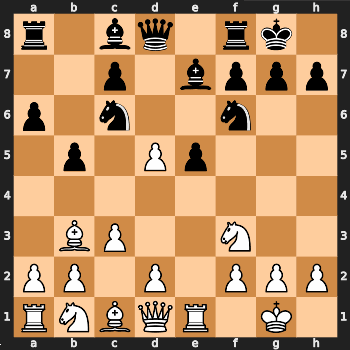

In [ ]:
# Crear un tablero inicial. Gambito Marshall.
board = chess.Board(fen='r1bq1rk1/2p1bppp/p1n2n2/1p1pp3/4P3/1BP2N2/PP1P1PPP/RNBQR1K1 w - d6 0 9')

# Lista para almacenar los frames del GIF
frames = []

for i in range(70):
    try:
        # Encontrar la mejor jugada con profundidad 2
        move,eval = best_move(board, depth=2)
        print(f"La mejor jugada es: {move}")
        print("La evaluación es {}".format(eval))


        # Realizar la jugada en el tablero
        board.push(move)

        # Generar el SVG del tablero
        svg_image = chess.svg.board(board, size=350)

        # Convertir el SVG a PNG usando Wand
        with WandImage(blob=svg_image.encode("utf-8"), format="svg") as img:
            img.format = "png"
            png_data = io.BytesIO(img.make_blob("png"))
            frame = Image.open(png_data).convert("RGBA")
            frames.append(frame)
    except:
        pass # Esta línea ignora cualquier error durante la generación de frames.

# Guardar las imágenes como un GIF animado
gif_filename = "partida.gif" # Define el nombre del archivo para usarlo al guardar y mostrar
if frames: # Asegúrate de que haya frames antes de intentar guardar y mostrar
    try:
        frames[0].save(gif_filename, save_all=True, append_images=frames[1:], duration=1500, loop=0)
        print(f"GIF generado: {gif_filename}")

        # Mostrar el GIF en la salida
        from IPython.display import display, Image # Importa display y Image
        print("\nVisualizando el GIF en la salida:")
        try:
            display(Image(filename=gif_filename))
        except FileNotFoundError:
            print(f"Error al mostrar el GIF: El archivo {gif_filename} no fue encontrado.")
        except Exception as e:
            print(f"Error al mostrar el GIF: {e}")

        # Fin de mostrar el GIF

    except Exception as e:
        print(f"Error al guardar el GIF: {e}")

else:
    print("No se generaron frames para el GIF.")

## 10. Conclusión

En este ejercicio se logró implementar un modelo de regresión logística manual y aplicarlo como función de evaluación en un motor de ajedrez propio. El motor fue capaz de jugar partidas automáticas desde una posición compleja, utilizando características extraídas del tablero y parámetros aprendidos del dataset.